# Detecting intrusion using login data

### Using logistic regression, I aim to predict whether login attempts are malicious. Based on the accuracy of the result, I will also explore whether thresholds should be set to balance security with user experience (such as requiring MFA vs blocking the login attempt altogether)

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

## Data Exploration

### I found this dataset on Kaggle: https://www.kaggle.com/datasets/dnkumars/cybersecurity-intrusion-detection-dataset?select=cybersecurity_intrusion_data.csv

That has almost 10,000 login attempts to a fictional website, including a target variable of "attack detected"

In [84]:
raw_data = pd.read_csv('cybersecurity_intrusion_data.csv')
df = raw_data.copy()
df.shape

(9537, 11)

In [ ]:
df.head()

In [ ]:
df.info()

In [85]:
categorical = ['protocol_type', 'encryption_used', 'browser_type']
numeric = ['network_packet_size', 'login_attempts', 'session_duration', 'ip_reputation_score', 'failed_logins', 'unusual_time_access', 'attack_detected']

There are no null fields, so there is no need to impute values. One observation is that location is not considered which would be a very strong indicator

Let's see how many of the login attempts were detected attacks

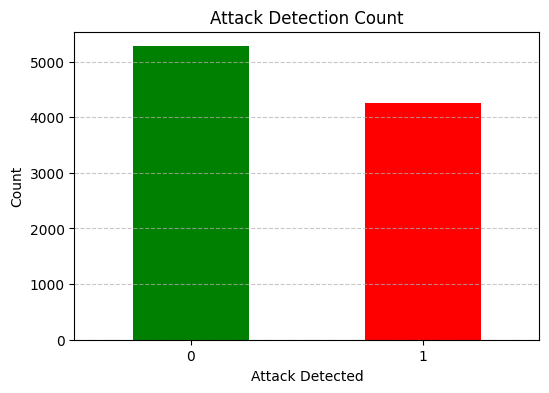

In [86]:
attack_counts = df.attack_detected.value_counts()

plt.figure(figsize=(6,4))
attack_counts.plot(kind='bar', color=['green', 'red'])
plt.xlabel("Attack Detected")
plt.ylabel("Count")
plt.title("Attack Detection Count")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle="--", alpha=0.7)

plt.show()

It looks like there are quite a few attacks detected by the manually labeled data. Let's determine if any of the features are correlated with each other

Now let's determine if any of the features are correlated with each other

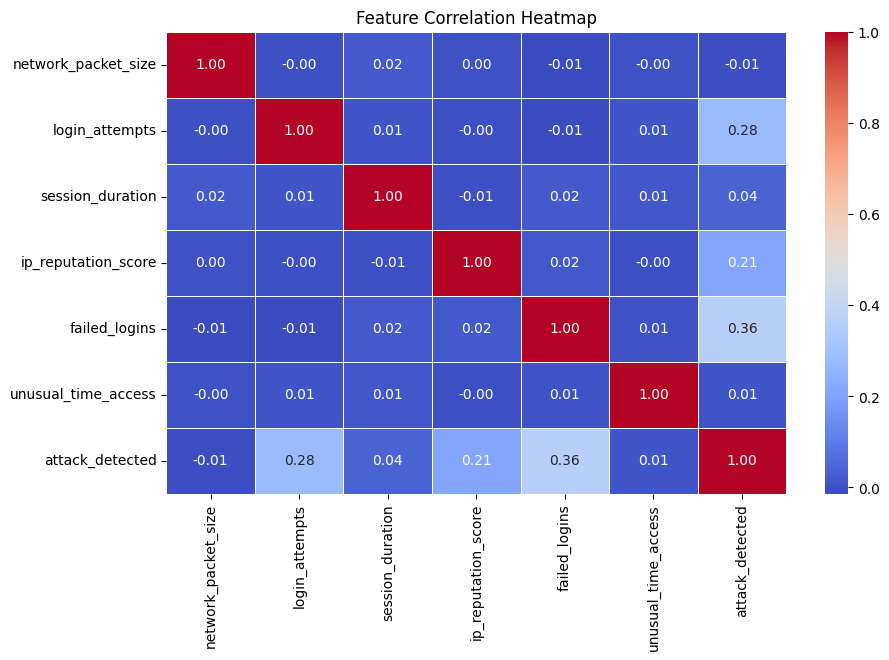

In [87]:
df_numeric = df[numeric] 

# Compute the correlation matrix
corr_matrix = df_numeric.corr()

# Set figure size
plt.figure(figsize=(10, 6))

# Create heatmap
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Title
plt.title("Feature Correlation Heatmap")

# Show plot
plt.show()

Looks like there is relatively little correlation between variables. Let's get on to preparing the data!

## Preparing the data

I'm going to make the decision to omit session_duration. This might be useful if we were to enforce a lockout period, but it won't be helpful in determining whether the any future authentication attempts are malicious

In [91]:
X = df.drop(['attack_detected', 'session_id', 'session_duration'], axis=1)
numeric.remove('attack_detected')
numeric.remove('session_duration')
y = df['attack_detected']

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [93]:
X_train.head()

,network_packet_size,protocol_type,login_attempts,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access
9194,298,UDP,4,DES,0.178229,3,Chrome,0
8561,641,TCP,6,AES,0.474200,1,Firefox,0
7778,454,ICMP,2,DES,0.559826,2,Unknown,1
6785,415,TCP,2,DES,0.569155,0,Firefox,0
4920,832,TCP,2,AES,0.015135,0,Edge,1


In [96]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False), categorical),
        ('num', StandardScaler(), numeric)
    ],
    remainder='passthrough'
)

In [97]:
model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=0))
])

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['protocol_type',
                                                   'encryption_used',
                                                   'browser_type']),
                                                 ('num', StandardScaler(),
                                                  ['network_packet_size',
                                                   'login_attempts',
                                                   'ip_reputation_score',
                                                   'failed_logins',
                                                   'unusual_time_access'])])),
                ('classifier',
                 LogisticRegression(random_state=0, solver='liblinear'))])

Time to see how we did!

In [ ]:
y_pred_train = model.predict(X_train)
print('Train model accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Model accuracy score: 0.7414


In [101]:
y_pred_test = model.predict(X_test)
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred_test)))

Model accuracy score: 0.7432


No signs of overfitting, so that's great. Let's dive deeper into the model's performance

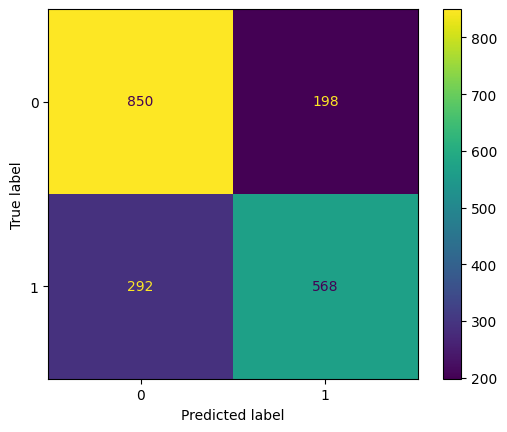

In [106]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

In [111]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.74      0.81      0.78      1048
           1       0.74      0.66      0.70       860

    accuracy                           0.74      1908
   macro avg       0.74      0.74      0.74      1908
weighted avg       0.74      0.74      0.74      1908



It looks like the model is quite good at identifying legitimate auth attempts, but there are a few malicious attempts that are slipping through the cracks

1. How can we improve the model?
2. Is there a confidence level we can print from the model on the test data to see where we should draw thresholds?

Look into cross validating results

Here's a great example on Kaggle: https://www.kaggle.com/code/nukimayasari/cybersecurity-intrusion